In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor

In [88]:
df = pd.read_csv("Predict_ready_df")

In [89]:
df.drop(df[df['idle_time']==0].index,inplace= True)

In [90]:
df

,Unnamed: 0,timestamp,station_id,bike_id,idle_time,temperature,rain,hour,IsWeekday,lat,lon,near_bus_station,near_school,near_leisure_spots
1,1,2019-01-01 09:00:00,3,2191,113.283333,10.0,0,9,1,37.78638,-122.40490,0,0,1
2,2,2019-01-01 09:00:00,3,5063,107.800000,10.0,0,9,1,37.78638,-122.40490,0,0,1
3,3,2019-01-01 09:00:00,3,5262,98.400000,10.0,0,9,1,37.78638,-122.40490,0,0,1
4,4,2019-01-01 10:00:00,3,5354,31.116667,9.0,0,10,1,37.78638,-122.40490,0,0,1
5,5,2019-01-01 10:00:00,3,4760,25.700000,9.0,0,10,1,37.78638,-122.40490,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3132765,3132765,2019-12-23 17:00:00,498,12424,1.083333,10.0,0,17,1,37.72589,-122.45244,0,1,1
3132766,3132766,2019-12-23 17:00:00,498,353685,975.483333,10.0,0,17,1,37.72589,-122.45244,0,1,1
3132767,3132767,2019-12-24 10:00:00,498,10310,196.016667,8.0,0,10,1,37.72589,-122.45244,0,1,1
3132768,3132768,2019-12-30 14:00:00,498,10962,0.383333,9.0,0,14,1,37.72589,-122.45244,0,1,1


# Transform cyclic features

In [92]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

hour_arr = np.array(df['hour'])


df['hour_sin'] = sin_transformer(24).fit_transform(hour_arr.reshape(-1,1))
df['hour_cos'] = cos_transformer(24).fit_transform(hour_arr.reshape(-1,1))


# Remove outlier

In [93]:
# Assuming you have a DataFrame named 'df' and want to remove outliers from column 'column_name'

# Calculate the z-scores for each value in the column
z_scores = np.abs((df['idle_time'] - df['idle_time'].mean()) / df['idle_time'].std())

# Define a threshold for outliers (e.g., z-score > 3)
threshold = 1.5

# Create a boolean mask indicating the outliers
outliers_mask = z_scores > threshold

# Remove outliers from the column by replacing them with NaN values
df.loc[outliers_mask, 'idle_time'] = np.nan

# Return the modified column back to the original DataFrame
df = df.dropna(subset=['idle_time']) # Replace NaN values with median or any other desired method

In [94]:
df['idle_time'].max()

790.9333333333333

(0.0, 200.0)

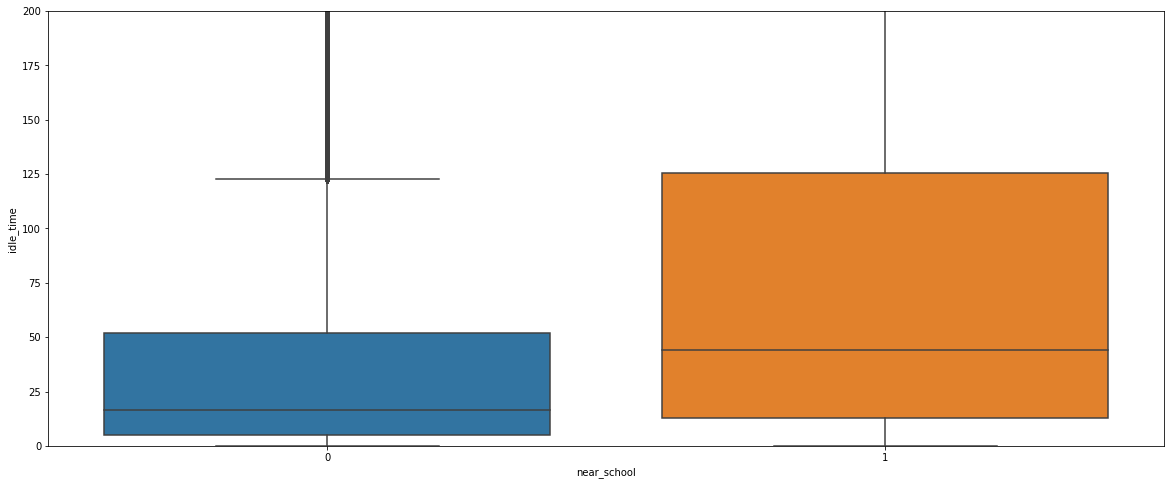

In [177]:
fig,ax = plt.subplots(figsize=(20,8)) 
sns.boxplot(x=df.near_school, y= df.idle_time)
plt.ylim(0,200)


In [163]:
xp = df[['temperature','rain','hour_sin','hour_cos','near_bus_station','near_school','near_leisure_spots',
        'IsWeekday']].values

yp= df['idle_time'].values

In [164]:
X_train_val, X_test, y_train_val, y_test = train_test_split(xp, yp, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

Scaling features

In [138]:
from sklearn.preprocessing import PolynomialFeatures
degree = 2
poly = PolynomialFeatures(degree= degree,include_bias= False)
poly_x = poly.fit_transform(X_train.reshape(-1,1))
poly_test = poly.transform(X_test.reshape(-1,1))
poly_val = poly.transform(X_val.reshape(-1,1))


In [140]:
poly_x =poly_x.reshape(-1,14)
poly_test = poly_test.reshape(-1,14)
poly_val= poly_val.reshape(-1,14)

In [120]:


from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
poly_x[:,:2] = scaler.fit_transform(poly_x[:, :2])
poly_test[:,:2]= scaler.transform(poly_test[:,:2])
poly_val[:,:2]= scaler.transform(poly_val[:,:2])



In [165]:
X_train[:,:2] = scaler.fit_transform(X_train[:, :2])
X_test[:,:2]= scaler.transform(X_test[:,:2])
X_val[:,:2]= scaler.transform(X_val[:,:2])



In [59]:
poly_val.shape

(461866, 18)

In [45]:
scaler_y = StandardScaler()

In [46]:


y_train_scaled =scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_scaled =scaler_y.transform(y_test.reshape(-1,1))

In [18]:
len(y_train)

2189789

In [166]:

# define base model

 # create model
model = Sequential()
model.add(Dense(20, input_shape=(8,), kernel_initializer='normal', activation='relu'))
model.add(Dense(4, kernel_initializer='normal', activation='relu'))



model.add(Dense(1, kernel_initializer='normal'))
 # Compile model
model.compile(loss='mean_squared_error', optimizer='adam'
             )


In [167]:
model.fit(X_train,y_train, batch_size =50, epochs = 50)

Epoch 1/50
43075/43075 [==============================] - 115s 3ms/step - loss: 13822.7549
Epoch 2/50
43075/43075 [==============================] - 107s 2ms/step - loss: 13568.2109
Epoch 3/50
43075/43075 [==============================] - 123s 3ms/step - loss: 13545.0615
Epoch 4/50
30987/43075 [====================>.........] - ETA: 35s - loss: 13505.1797

KeyboardInterrupt: 

In [ ]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold, scoring='neg_mean_squared_error')
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))


In [142]:
# let's fit the model



# we use linear regression as a base!!! ** sometimes misunderstood **
regression_model = LinearRegression()

regression_model.fit(poly_x, y_train)
print(regression_model.coef_ ,regression_model.intercept_)
regression_model.coef_
regression_model.intercept_







[-5.39738093e+09  5.39738094e+09  6.23683262e+00  9.62139491e+09
  1.21539770e+02  9.62139502e+09  4.05167003e+10 -4.05167003e+10
 -1.43205474e+11  1.43205475e+11  1.63449485e+10 -1.63449486e+10
  5.36943521e+10 -5.36943521e+10] -9621394806.824642


-9621394806.824642

In [30]:
from sklearn.linear_model import Ridge

# initialize model
model_L2 = Ridge(alpha = 0.1, solver = 'lsqr') # select least squares regression as solver

# train model
model_L2.fit(poly_x, y_train)


print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

Coefficients  [ -0.50857752   1.64219033   0.9452194   -0.81484799  -1.69369464
   2.90151192   2.90151192   2.90151192   2.90151192   2.90151192
   7.24488373 -28.76504506  -2.35087354 -39.87099422  -1.8737638
 120.15378098  28.76504506 -24.29550885  17.65909591  34.5629423
  -3.88556999  -3.88556999  -3.88556999  -3.88556999  -3.88556999
   8.81271438   8.81271438   8.81271438   8.81271438   8.81271438
  -5.60512452  -5.60512452  -5.60512452  -5.60512452  -5.60512452
 -26.79609254  -9.01115399 -19.38629759 -14.37092786   4.77844325
 -91.8132902    9.01115399  21.48065921   3.65138013 -22.2427346 ] 
Intercept  238.01958642374493


In [145]:
from sklearn.linear_model import Lasso

model_L1 = Lasso(alpha = 0.9)

model_L1.fit(poly_x, y_train)

print("Coefficients ", model_L1.coef_, "\nIntercept ", model_L1.intercept_ )

Coefficients  [ 2.17956189e-02  1.77733399e-14  3.19995868e+00 -1.62025180e+01
  1.12984553e+02  8.28338306e+01 -1.43953685e+01 -0.00000000e+00
  2.92175461e+01  3.73220139e-13 -1.82066611e+01 -4.87562633e-14
 -8.09500602e+00 -3.96599977e-14] 
Intercept  106.7823770454194


In [85]:
poly_val.shape

(4156794, 3)

In [17]:
def plot_L2_regression_performance ():

    err_train = []
    err_cv = []
    
    

    for alpha in np.logspace(-20,-10,20):

        
        
        

        # fit model
        model_L2 = Ridge(alpha = alpha, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(poly_x, y_train)
    
        # compute errors
        err_train.append(mean_squared_error(model_L2.predict(poly_x), y_train))
        err_cv.append(mean_squared_error(model_L2.predict(poly_val), y_val))


    plt.figure(figsize = (8,6))
    plt.loglog(np.logspace(-20,-10,20), err_train, np.logspace(-20,-10,20), err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("$\lambda$ (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    plt.show()

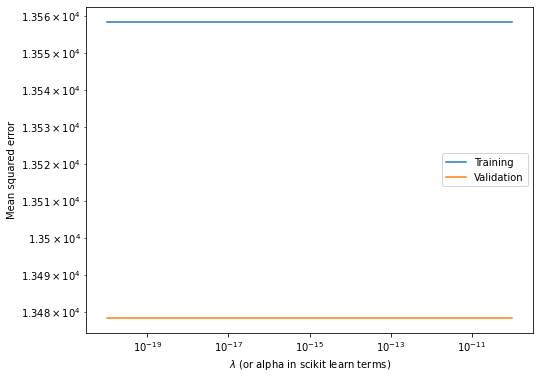

In [18]:
plot_L2_regression_performance()

In [148]:

train_pred = model_L1.predict(poly_x)
print("Test set performance:")

print("MAE:",mean_absolute_error(y_train, train_pred))
print("RMSE:",(mean_squared_error(y_train, train_pred))**(0.5))  
print("R2:",r2_score(y_train, train_pred))

Test set performance:
MAE: 65.51812565946308
RMSE: 117.02547613176198
R2: 0.19188535719163857
